# Lecture 2A - simulation of a two-qubit gate using a resonator as coupler

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, basis, concurrence, destroy, expect, fidelity,
                   ket2dm, mesolve, ptrace, qeye, sigmaz,
                   tensor)
from qutip_qip.operations import phasegate, sqrtiswap
from scipy.special import sici

%matplotlib inline

## Parameters

In [2]:
N = 10

wc = 5.0 * 2 * np.pi
w1 = 3.0 * 2 * np.pi
w2 = 2.0 * 2 * np.pi

g1 = 0.01 * 2 * np.pi
g2 = 0.0125 * 2 * np.pi

tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1 * np.pi) / (4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2 * np.pi) / (4 * g2)

### Operators, Hamiltonian and initial state 

In [3]:
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [4]:
# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = -0.5 * sz1
H2 = -0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2

In [5]:
H

Quantum object: dims=[[10, 2, 2], [10, 2, 2]], shape=(40, 40), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-15.70796327   0.           0.         ...   0.           0.
    0.        ]
 [  0.          -3.14159265   0.         ...   0.           0.
    0.        ]
 [  0.           0.           3.14159265 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 279.60174617   0.
    0.        ]
 [  0.           0.           0.         ...   0.         285.88493148
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  298.45130209]]

In [6]:
# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N, 0), basis(2, 1), basis(2, 0))

# Ideal two-qubit iSWAP gate

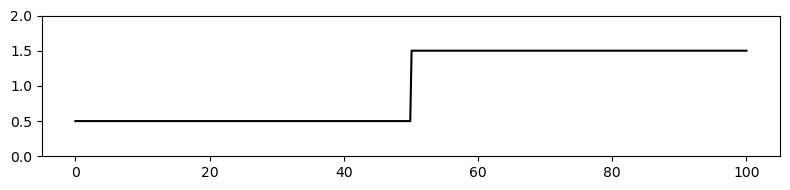

In [7]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t.
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8, 2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, 0.0, t) for t in tlist], "k")
axes.set_ylim(0, 2)
fig.tight_layout()

In [8]:
def wc_t(t, args=None):
    return wc


def w1_t(t, args=None):
    return (
        w1
        + step_t(0.0, wc - w1, T0_1, width, t)
        - step_t(0.0, wc - w1, T0_1 + T_gate_1, width, t)
    )


def w2_t(t, args=None):
    return (
        w2
        + step_t(0.0, wc - w2, T0_2, width, t)
        - step_t(0.0, wc - w2, T0_2 + T_gate_2, width, t)
    )


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1 + Hc2]

### Evolve the system

In [9]:
res = mesolve(H_t, psi0, tlist, [])

### Plot the results

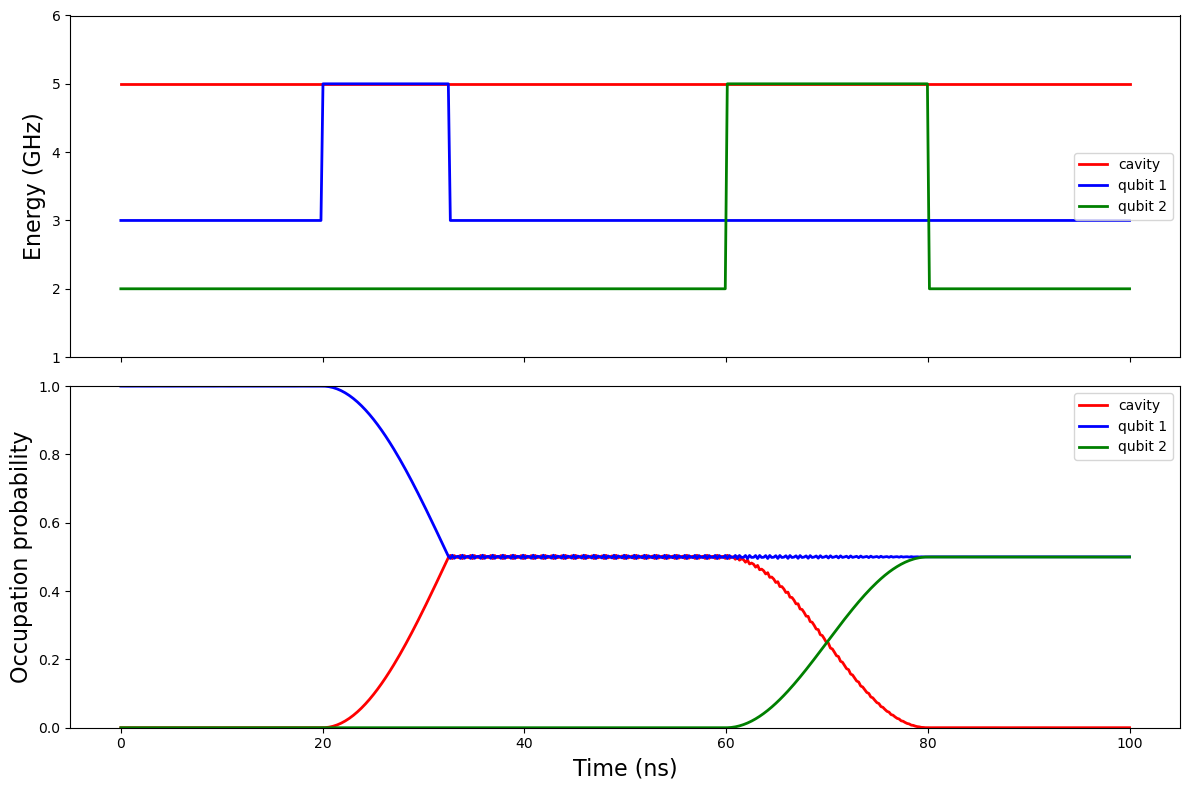

In [10]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].plot(
    tlist,
    np.array(list(map(wc_t, tlist))) / (2 * np.pi),
    "r",
    linewidth=2,
    label="cavity",
)
axes[0].plot(
    tlist,
    np.array(list(map(w1_t, tlist))) / (2 * np.pi),
    "b",
    linewidth=2,
    label="qubit 1",
)
axes[0].plot(
    tlist,
    np.array(list(map(w2_t, tlist))) / (2 * np.pi),
    "g",
    linewidth=2,
    label="qubit 2",
)
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), "r",
             linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), "b",
             linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), "g",
             linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Inspect the final state

In [11]:
# extract the final state from the result of the simulation
rho_final = res.states[-1]

In [12]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1, 2])
rho_qubits

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 6.16909624e-05+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          4.99792755e-01+0.j
  -4.99575083e-01+0.01984594j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -4.99575083e-01-0.01984594j
   5.00145554e-01+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]]

In [13]:
# compare to the ideal result of the sqrtiswap gate (plus phase correction)
# for the current initial state
rho_qubits_ideal = ket2dm(
    tensor(phasegate(0), phasegate(-np.pi / 2))
    * sqrtiswap()
    * tensor(basis(2, 1), basis(2, 0))
)
rho_qubits_ideal

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

### Fidelity and concurrence

In [14]:
fidelity(rho_qubits, rho_qubits_ideal)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


np.float64(0.01985124765433188)

In [15]:
concurrence(rho_qubits)

np.float64(0.9999382347290824)

# Dissipative two-qubit iSWAP gate

### Define collapse operators that describe dissipation



In [16]:
kappa = 0.0001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [np.sqrt(kappa) * a, np.sqrt(gamma1) * sm1, np.sqrt(gamma2) * sm2]

### Evolve the system

In [17]:
res = mesolve(H_t, psi0, tlist, c_ops)

### Plot the results

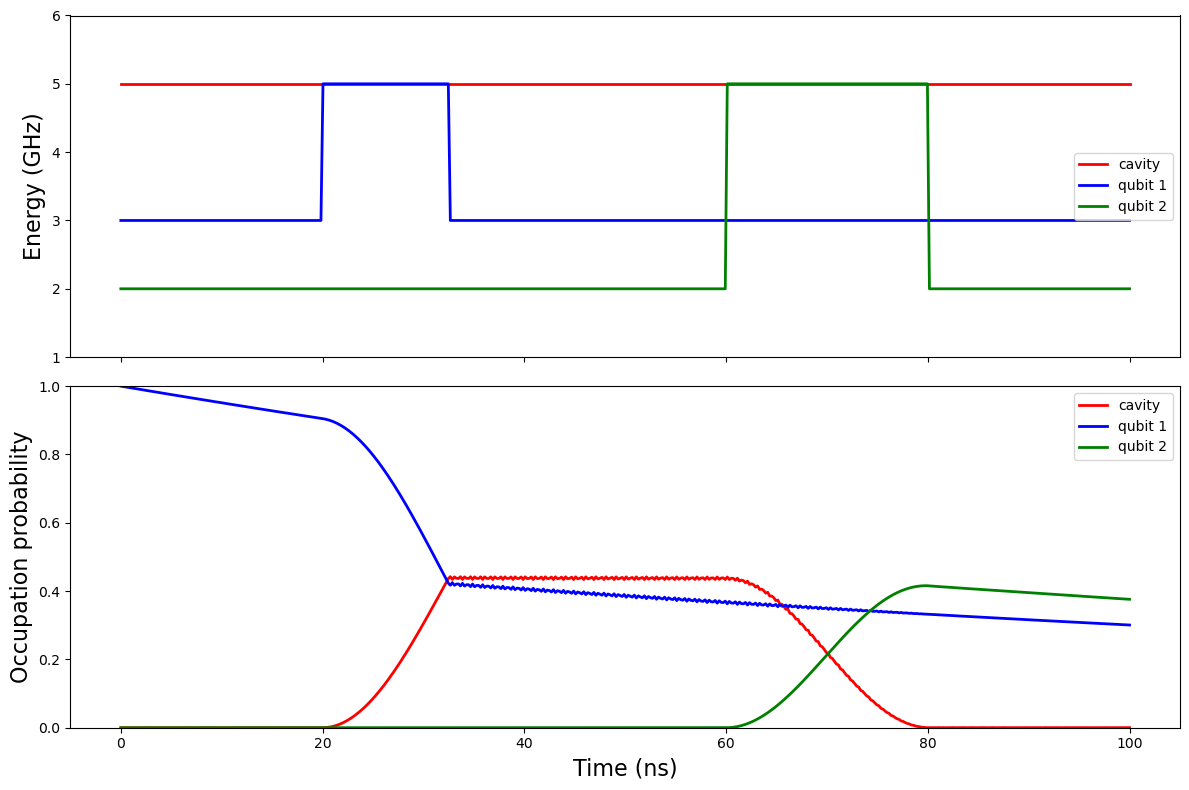

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].plot(
    tlist,
    np.array(list(map(wc_t, tlist))) / (2 * np.pi),
    "r",
    linewidth=2,
    label="cavity",
)
axes[0].plot(
    tlist,
    np.array(list(map(w1_t, tlist))) / (2 * np.pi),
    "b",
    linewidth=2,
    label="qubit 1",
)
axes[0].plot(
    tlist,
    np.array(list(map(w2_t, tlist))) / (2 * np.pi),
    "g",
    linewidth=2,
    label="qubit 2",
)
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), "r", linewidth=2,
             label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), "b", linewidth=2,
             label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), "g", linewidth=2,
             label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [19]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1, 2])

In [20]:
fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.0)

In [21]:
concurrence(rho_qubits)

np.float64(0.6723786036093659)

# Two-qubit iSWAP gate: Finite pulse rise time

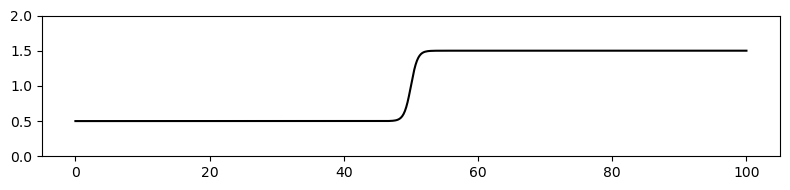

In [22]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time defined
    by the parameter width.
    """
    return w1 + (w2 - w1) / (1 + np.exp(-(t - t0) / width))


fig, axes = plt.subplots(1, 1, figsize=(8, 2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], "k")
axes.set_ylim(0, 2)
fig.tight_layout()

### Evolve the system

In [23]:
res = mesolve(H_t, psi0, tlist, [])

### Plot the results

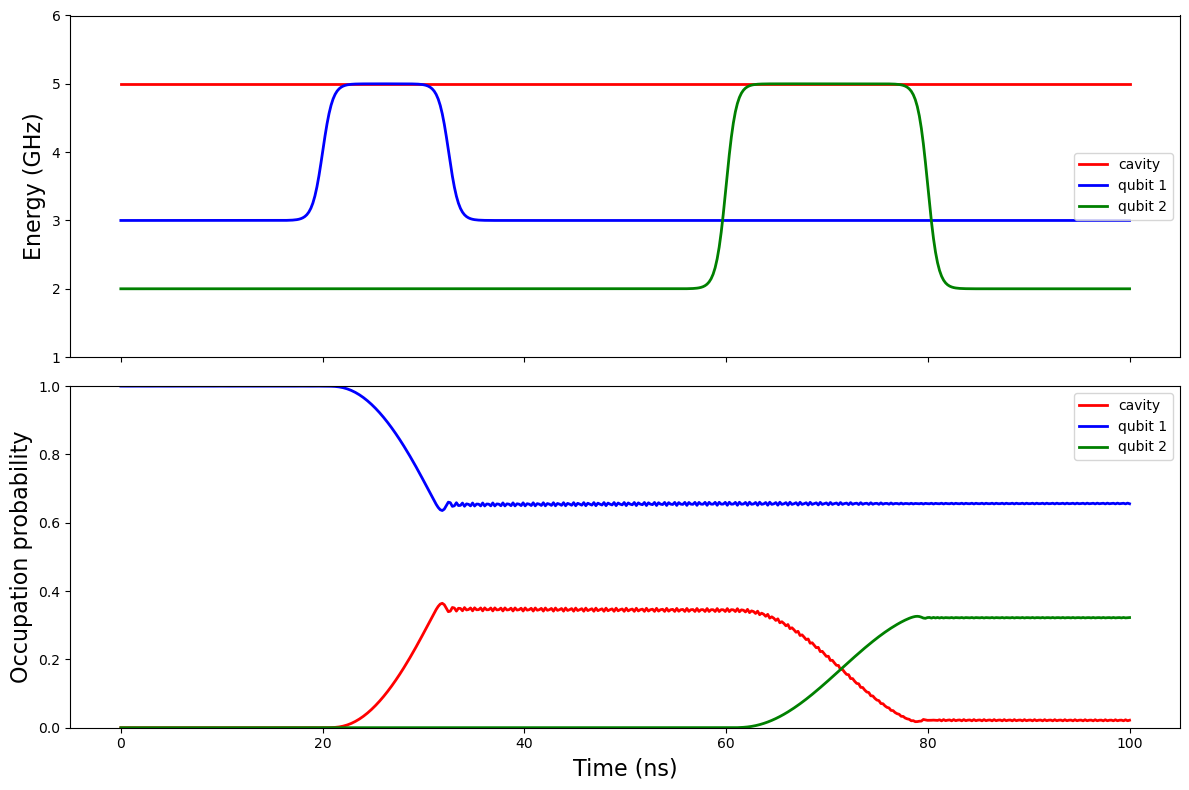

In [24]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].plot(
    tlist,
    np.array(list(map(wc_t, tlist))) / (2 * np.pi),
    "r",
    linewidth=2,
    label="cavity",
)
axes[0].plot(
    tlist,
    np.array(list(map(w1_t, tlist))) / (2 * np.pi),
    "b",
    linewidth=2,
    label="qubit 1",
)
axes[0].plot(
    tlist,
    np.array(list(map(w2_t, tlist))) / (2 * np.pi),
    "g",
    linewidth=2,
    label="qubit 2",
)
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), "r", linewidth=2,
             label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), "b", linewidth=2,
             label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), "g", linewidth=2,
             label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [25]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1, 2])

In [26]:
fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.17834178021546718)

In [27]:
concurrence(rho_qubits)

np.float64(0.9195849018245543)

# Two-qubit iSWAP gate: Finite rise time with overshoot

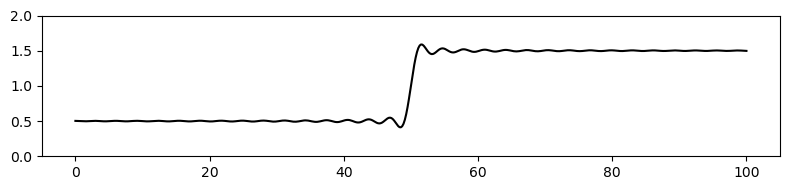

In [28]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time and
    and overshoot defined by the parameter width.
    """

    return w1 + (w2 - w1) * (0.5 + sici((t - t0) / width)[0] / (np.pi))


fig, axes = plt.subplots(1, 1, figsize=(8, 2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], "k")
axes.set_ylim(0, 2)
fig.tight_layout()

### Evolve the system

In [29]:
res = mesolve(H_t, psi0, tlist, [])

### Plot the results

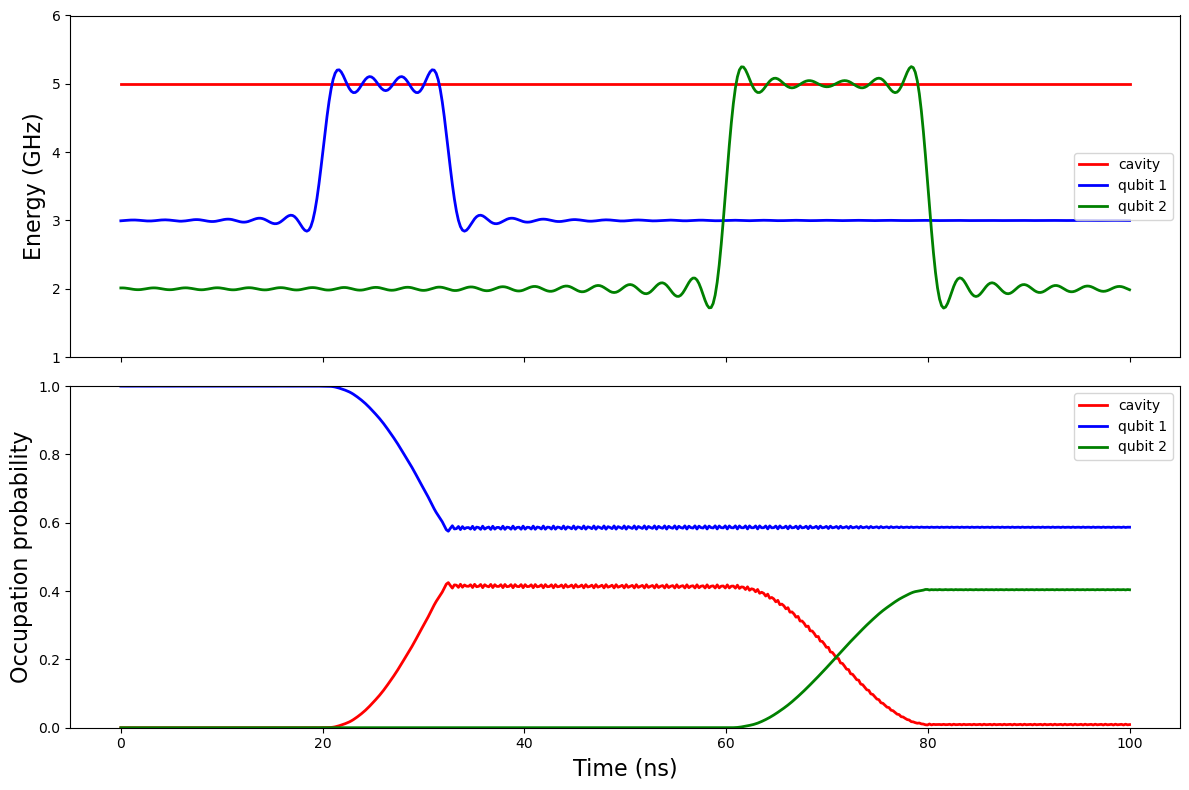

In [30]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].plot(
    tlist,
    np.array(list(map(wc_t, tlist))) / (2 * np.pi),
    "r",
    linewidth=2,
    label="cavity",
)
axes[0].plot(
    tlist,
    np.array(list(map(w1_t, tlist))) / (2 * np.pi),
    "b",
    linewidth=2,
    label="qubit 1",
)
axes[0].plot(
    tlist,
    np.array(list(map(w2_t, tlist))) / (2 * np.pi),
    "g",
    linewidth=2,
    label="qubit 2",
)
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), "r", linewidth=2,
             label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), "b", linewidth=2,
             label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), "g", linewidth=2,
             label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [31]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1, 2])

In [32]:
fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.1076018495596748)

In [33]:
concurrence(rho_qubits)

np.float64(0.9737582606156453)

# Two-qubit iSWAP gate: Finite pulse rise time and dissipation

In [34]:
# increase the pulse rise time a bit
width = 0.6

# high-Q resonator but dissipative qubits
kappa = 0.00001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [np.sqrt(kappa) * a, np.sqrt(gamma1) * sm1, np.sqrt(gamma2) * sm2]

### Evolve the system

In [35]:
res = mesolve(H_t, psi0, tlist, c_ops)

### Plot results

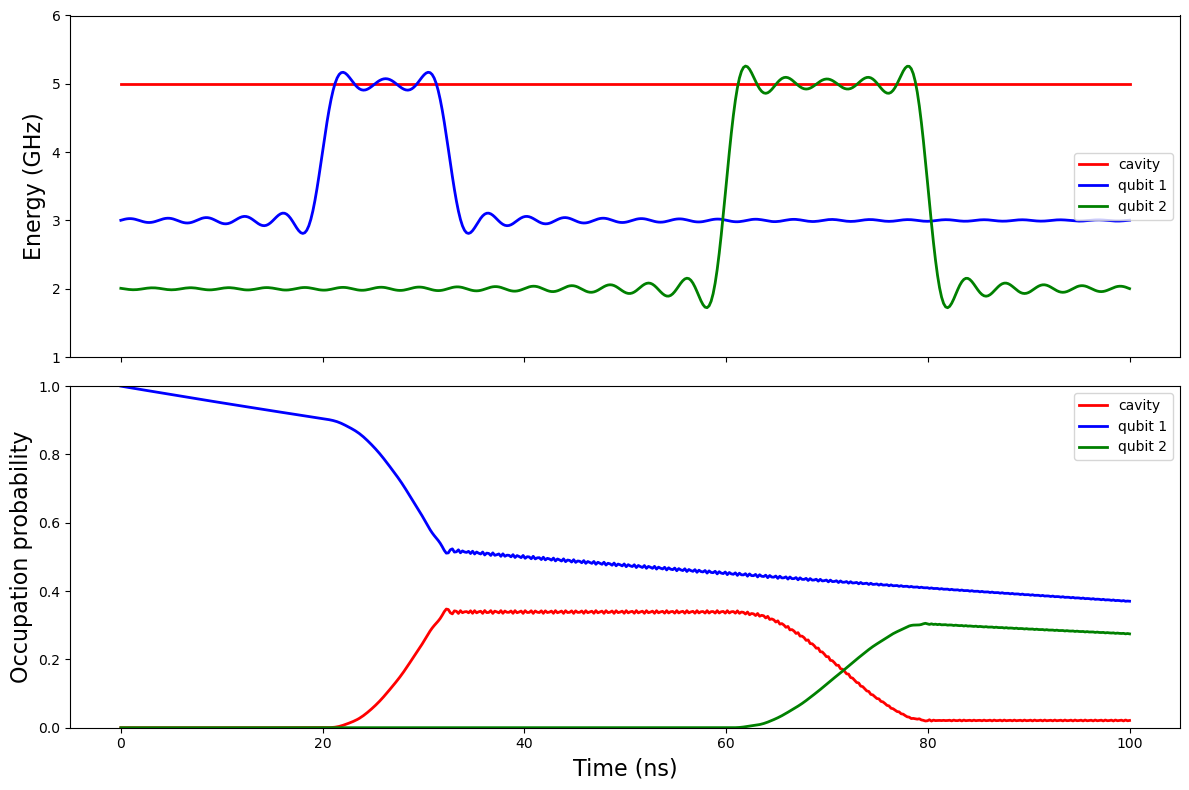

In [36]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].plot(
    tlist,
    np.array(list(map(wc_t, tlist))) / (2 * np.pi),
    "r",
    linewidth=2,
    label="cavity",
)
axes[0].plot(
    tlist,
    np.array(list(map(w1_t, tlist))) / (2 * np.pi),
    "b",
    linewidth=2,
    label="qubit 1",
)
axes[0].plot(
    tlist,
    np.array(list(map(w2_t, tlist))) / (2 * np.pi),
    "g",
    linewidth=2,
    label="qubit 2",
)
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), "r", linewidth=2,
             label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), "b", linewidth=2,
             label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), "g", linewidth=2,
             label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [37]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1, 2])

In [38]:
fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.11877418919957856)

In [39]:
concurrence(rho_qubits)

np.float64(0.6261569127216249)

# Two-qubit iSWAP gate: Using tunable resonator and fixed-frequency qubits

In [40]:
# reduce the rise time
width = 0.25


def wc_t(t, args=None):
    return (
        wc
        - step_t(0.0, wc - w1, T0_1, width, t)
        + step_t(0.0, wc - w1, T0_1 + T_gate_1, width, t)
        - step_t(0.0, wc - w2, T0_2, width, t)
        + step_t(0.0, wc - w2, T0_2 + T_gate_2, width, t)
    )


H_t = [[Hc, wc_t], H1 * w1 + H2 * w2 + Hc1 + Hc2]

### Evolve the system

In [41]:
res = mesolve(H_t, psi0, tlist, c_ops)

### Plot the results

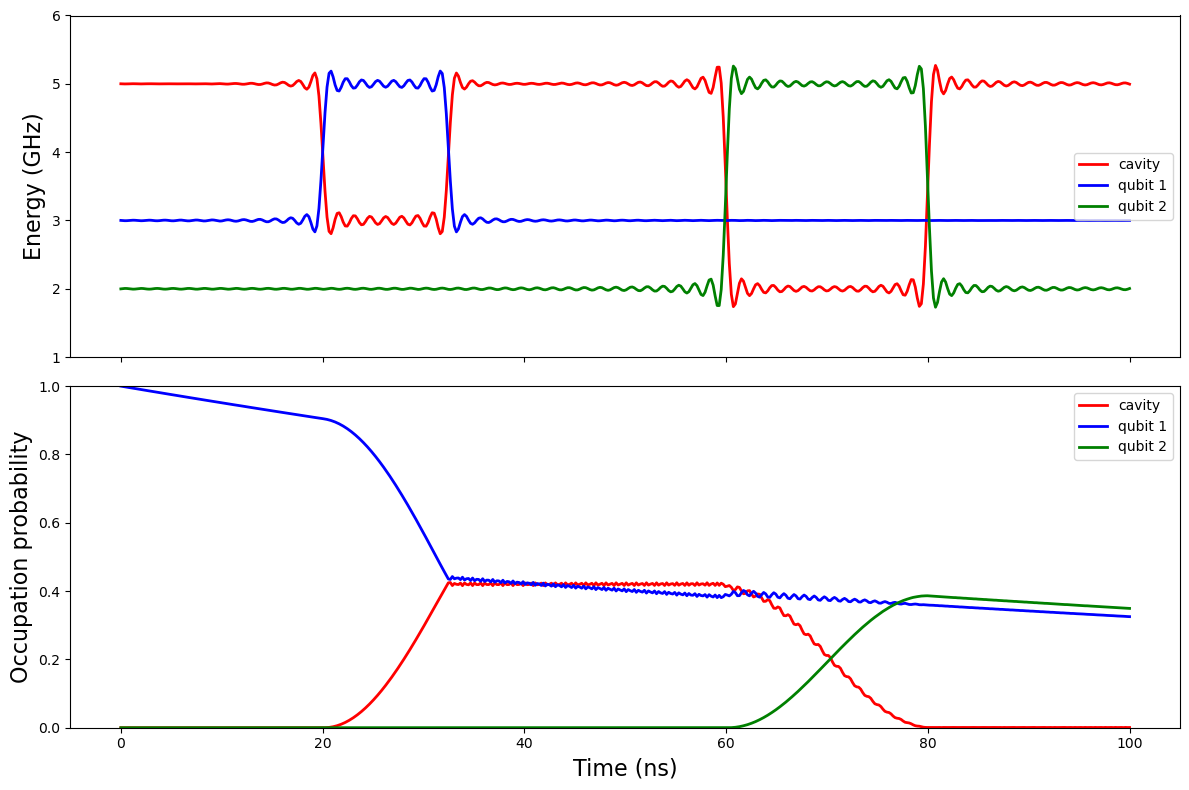

In [42]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].plot(
    tlist,
    np.array(list(map(wc_t, tlist))) / (2 * np.pi),
    "r",
    linewidth=2,
    label="cavity",
)
axes[0].plot(
    tlist,
    np.array(list(map(w1_t, tlist))) / (2 * np.pi),
    "b",
    linewidth=2,
    label="qubit 1",
)
axes[0].plot(
    tlist,
    np.array(list(map(w2_t, tlist))) / (2 * np.pi),
    "g",
    linewidth=2,
    label="qubit 2",
)
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), "r", linewidth=2,
             label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), "b", linewidth=2,
             label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), "g", linewidth=2,
             label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [43]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1, 2])

In [44]:
fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.02029339927764855)

In [45]:
concurrence(rho_qubits)

np.float64(0.6736823211144218)

### Software versions

In [46]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
